In [0]:
from __future__ import division
from __future__ import print_function

import time
import itertools

import numpy.random as npr

import jax.numpy as np
from jax.config import config
from jax import jit, grad, random,jvp
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, Sigmoid,Tanh,LeakyRelu,Conv,MaxPool,Flatten,Dropout

import numpy as onp
from torch.utils import data
from torchvision.datasets import MNIST
from jax.flatten_util import ravel_pytree
import matplotlib.pyplot as plt

In [0]:
from __future__ import absolute_import

import array
import gzip
import os
from os import path
import struct
from six.moves.urllib.request import urlretrieve

import numpy as onp


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return onp.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=onp.float32):
  """Create a one-hot encoding of x of size k."""
  return onp.array(x[:, None] == onp.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return onp.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return onp.array(array.array("B", fh.read()),
                      dtype=onp.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / onp.float32(255.)
  test_images = _partial_flatten(test_images) / onp.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = onp.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

In [0]:
def conj_grad(*p):

  g=[1e-2, 1e-2]

  f1 = lambda *params : loss(*params)[0]
  f2 = lambda *params : loss(*params)[1]

  D1f1 = grad(f1, argnums=0)
  D2f1 = grad(f1, argnums=1)
  D1f2 = grad(f2, argnums=0)
  D2f2 = grad(f2, argnums=1)
  D11f1 = lambda *p: lambda v: jvp(lambda x: D1f1(x, *p[1:]), (p[0],), (v,))[1]
  D12f1 = lambda *p: lambda v: jvp(lambda y: D1f1(p[0], y, *p[2:]), (p[1],), (v,))[1]
  D21f1 = lambda *p: lambda v: jvp(lambda x: D2f1(x, *p[1:]), (p[0],), (v,))[1]
  D22f1 = lambda *p: lambda v: jvp(lambda y: D2f1(p[0], y, *p[2:]), (p[1],), (v,))[1]
  D11f2 = lambda *p: lambda v: jvp(lambda x: D1f2(x, *p[1:]), (p[0],), (v,))[1]
  D12f2 = lambda *p: lambda v: jvp(lambda y: D1f2(p[0], y, *p[2:]), (p[1],), (v,))[1]
  D21f2 = lambda *p: lambda v: jvp(lambda x: D2f2(x, *p[1:]), (p[0],), (v,))[1]
  D22f2 = lambda *p: lambda v: jvp(lambda y: D2f2(p[0], y, *p[2:]), (p[1],), (v,))[1]

  r = lambda p: ravel_pytree(p)[0]
  return [r(D1f1(*p)) - g[0]*r(D12f2(*p)(D2f1(*p))),  \
               r(D2f2(*p)) - g[1]*r(D21f1(*p)(D1f2(*p)))]


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')


 HI We are training MNIST DATASET


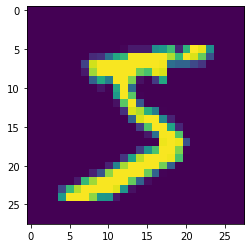


Starting training...


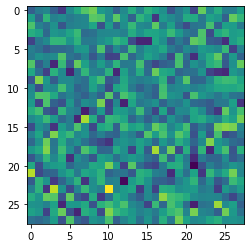

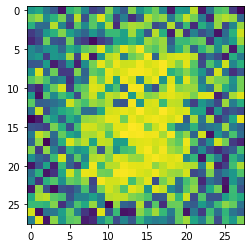

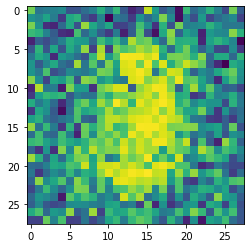

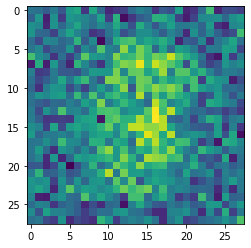

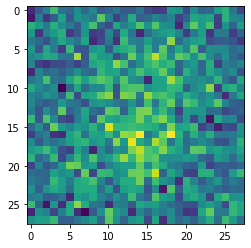

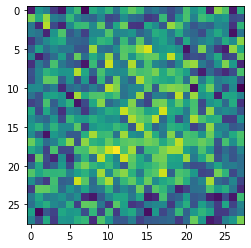

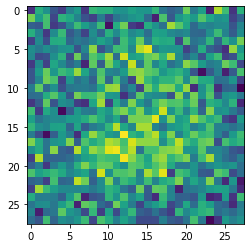

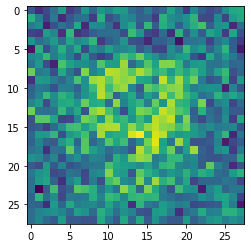

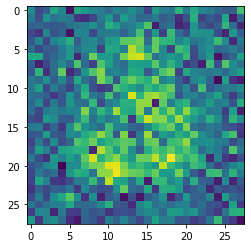

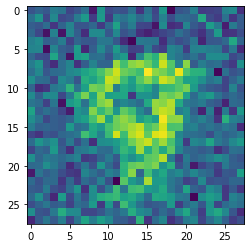

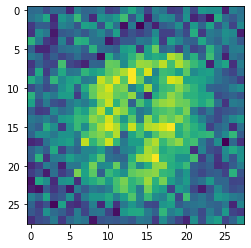

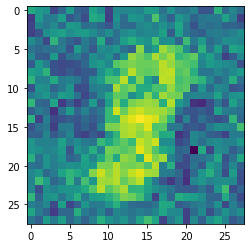

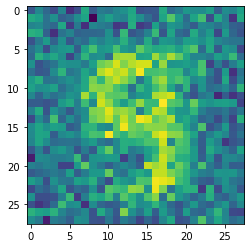

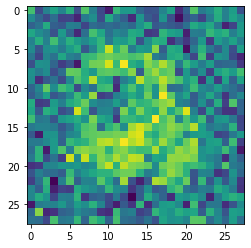

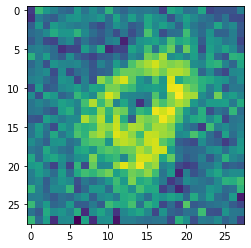

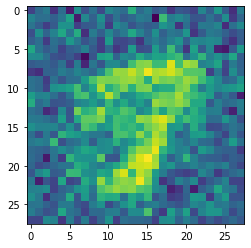

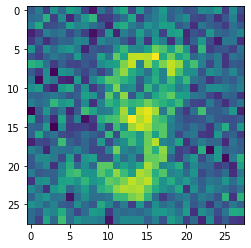

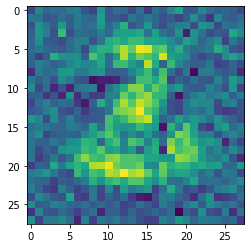

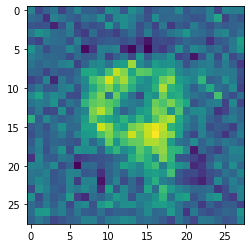

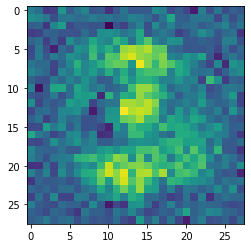

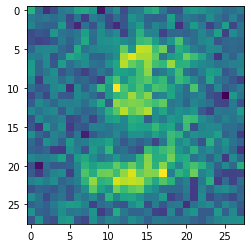

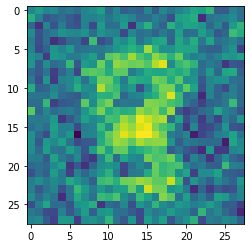

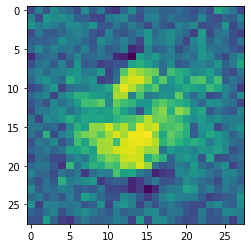

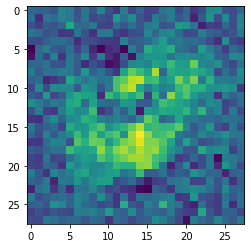

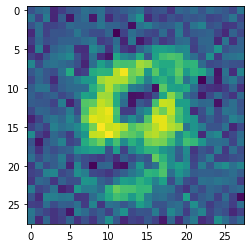

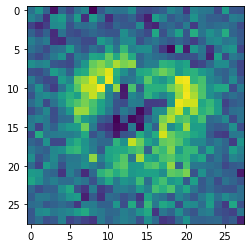

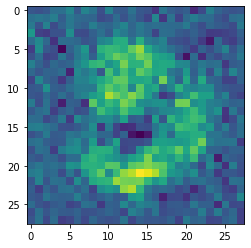

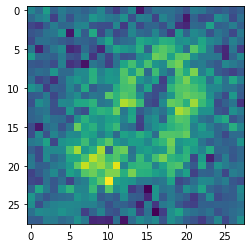

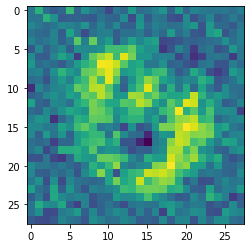

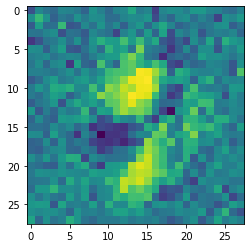

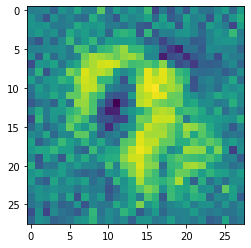

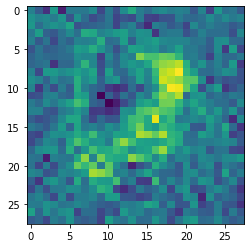

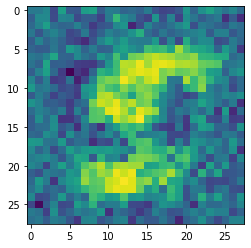

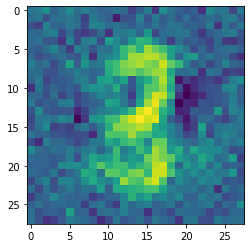

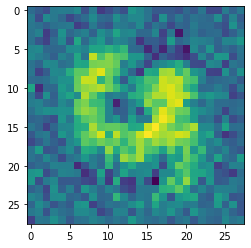

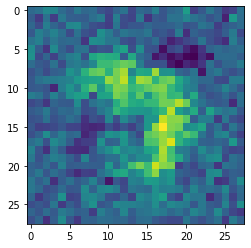

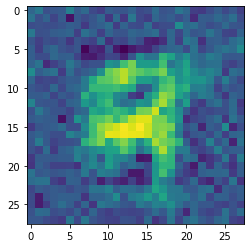

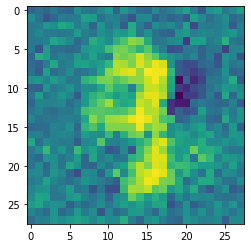

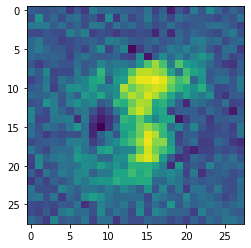

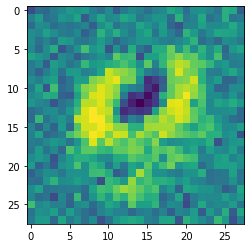

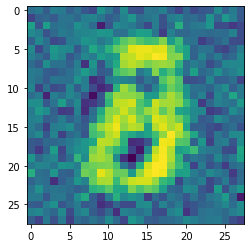

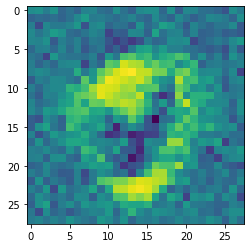

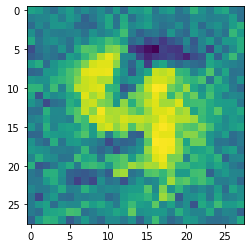

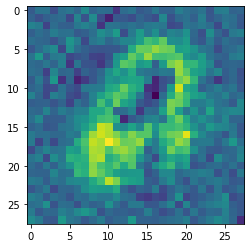

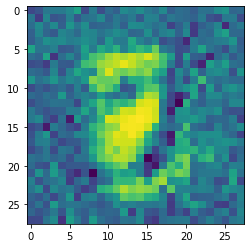

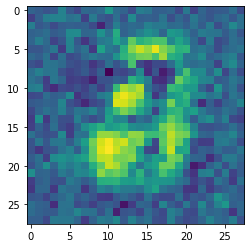

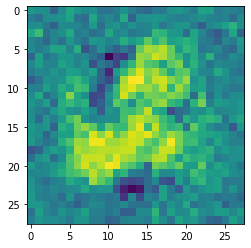

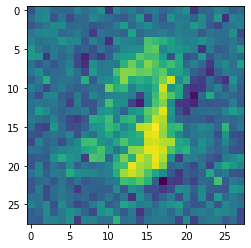

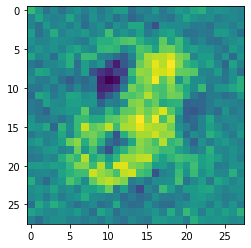

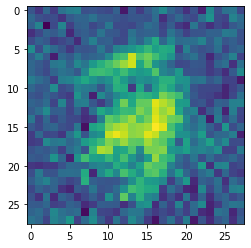

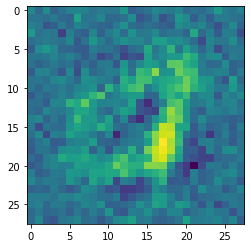

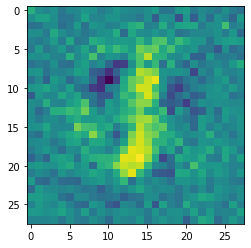

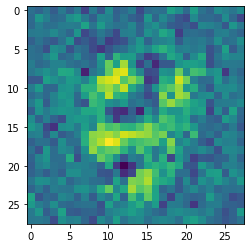

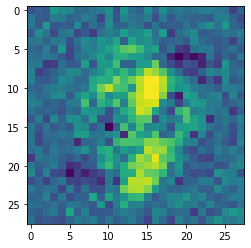

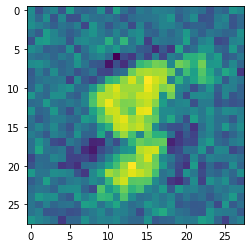

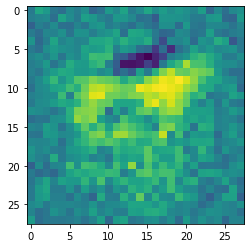

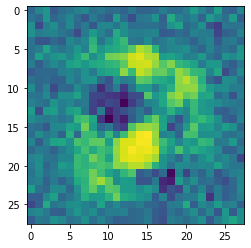

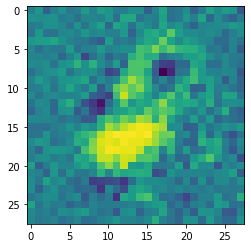

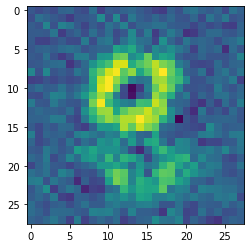

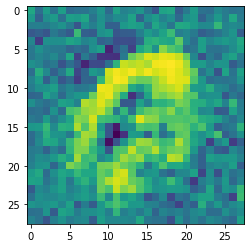

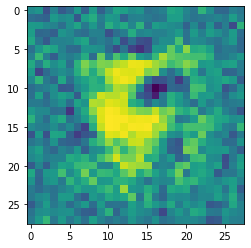

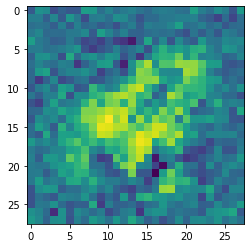

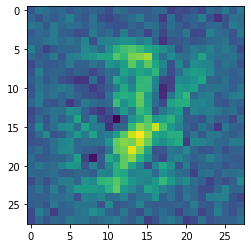

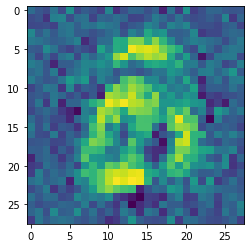

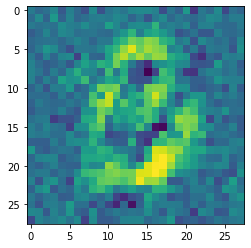

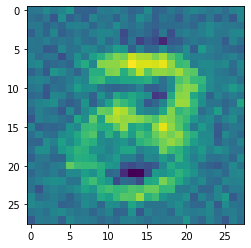

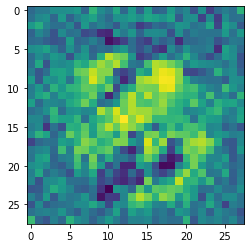

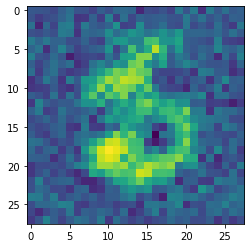

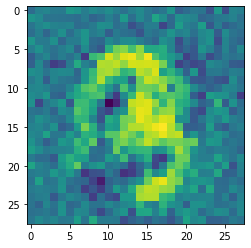

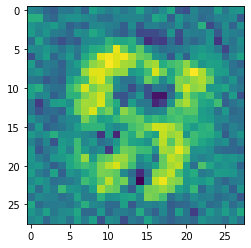

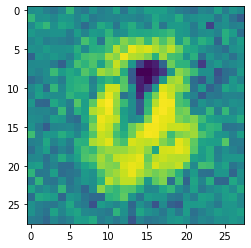

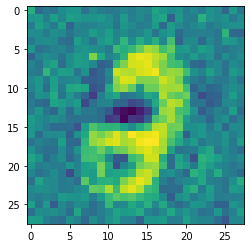

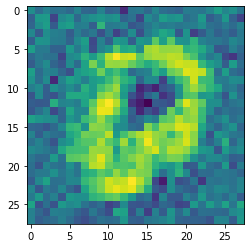

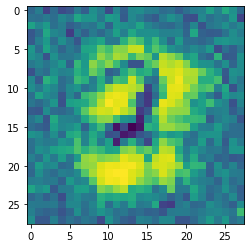

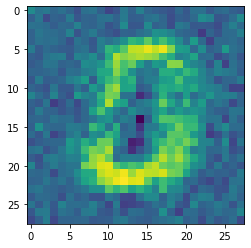

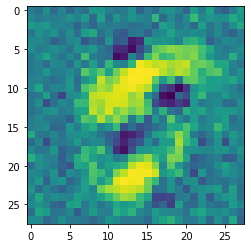

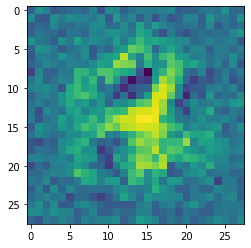

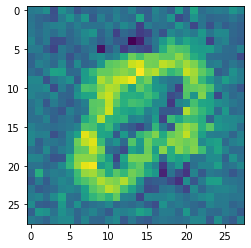

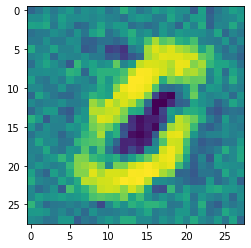

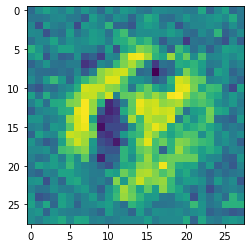

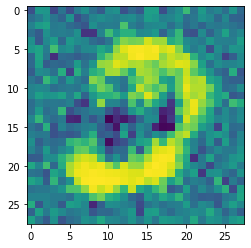

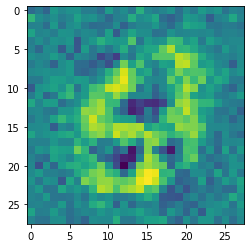

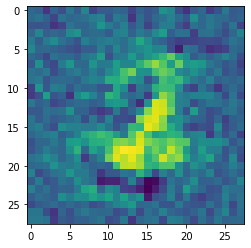

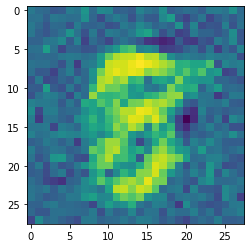

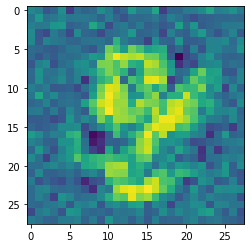

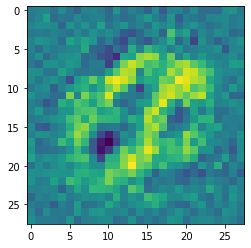

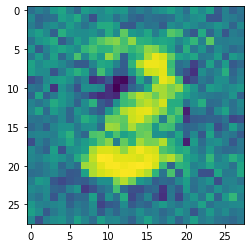

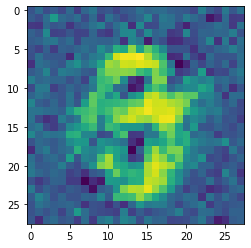

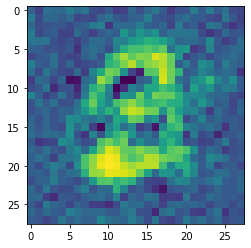

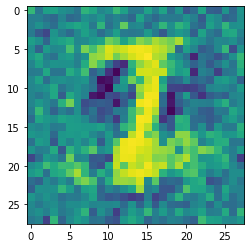

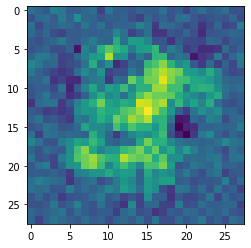

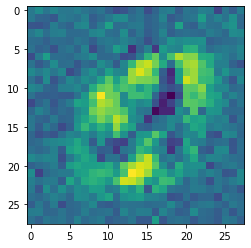

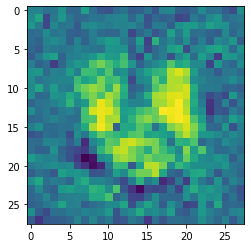

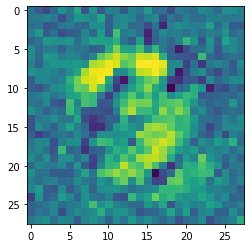

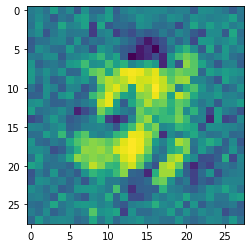

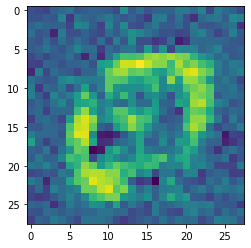

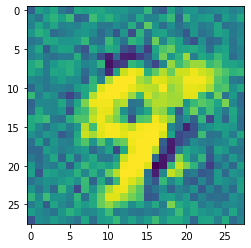

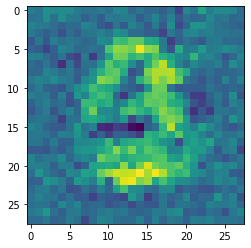

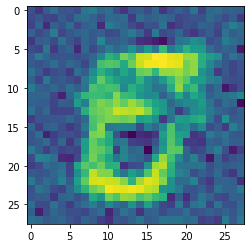

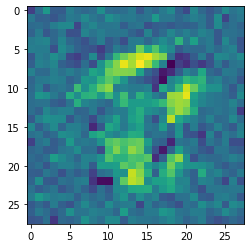

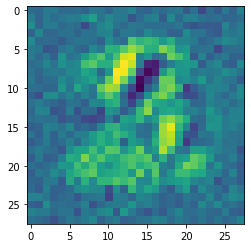

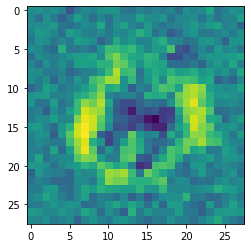

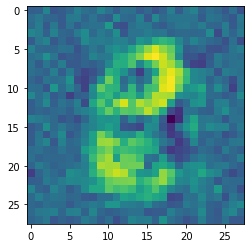

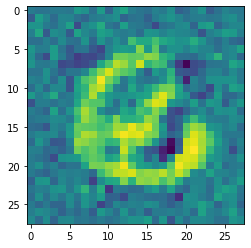

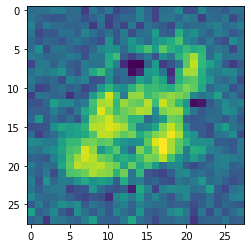

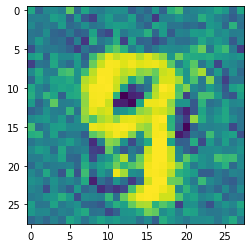

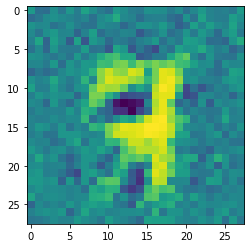

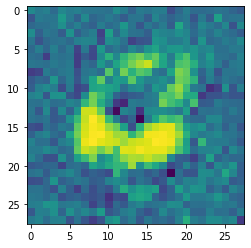

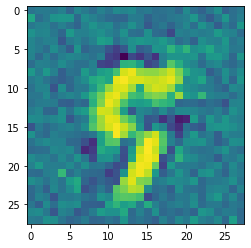

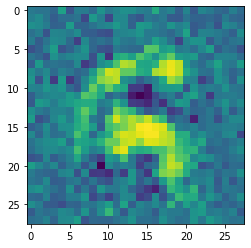

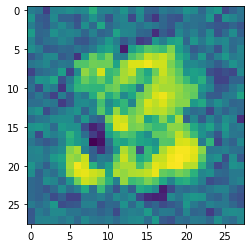

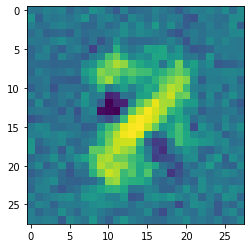

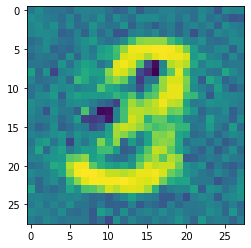

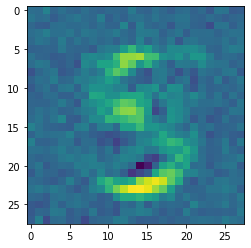

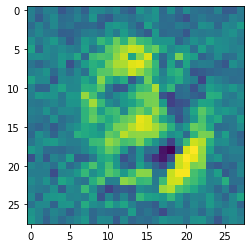

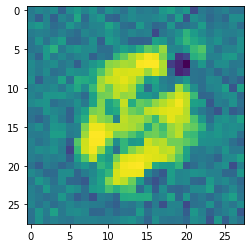

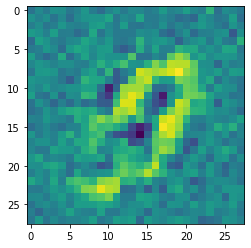

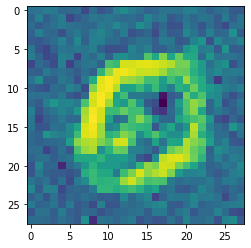

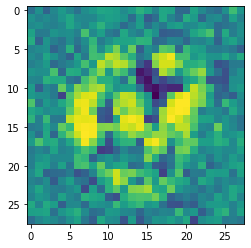

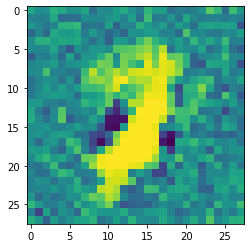

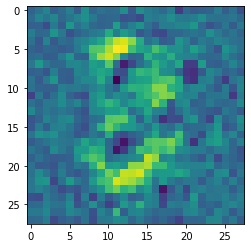

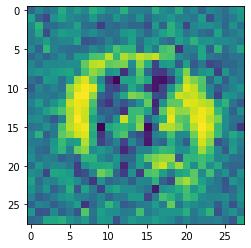

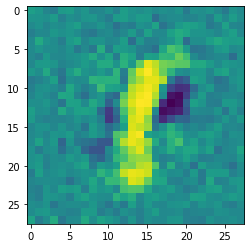

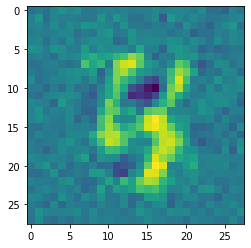

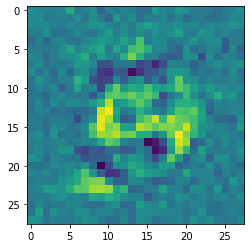

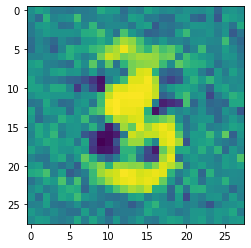

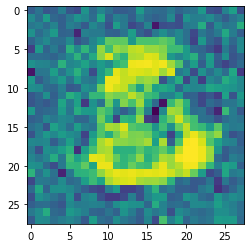

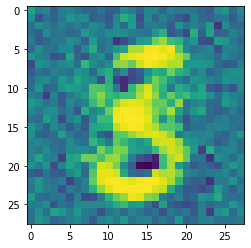

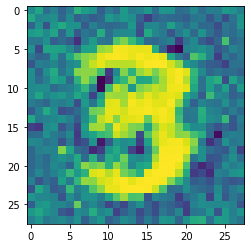

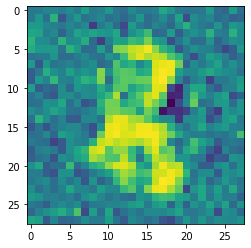

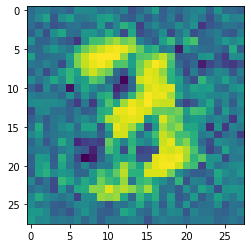

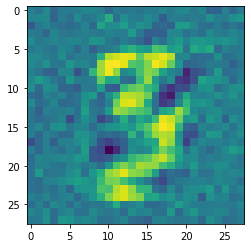

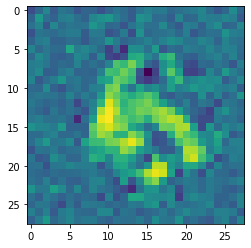

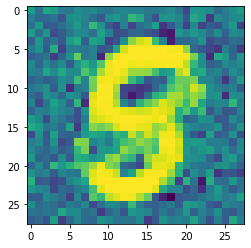

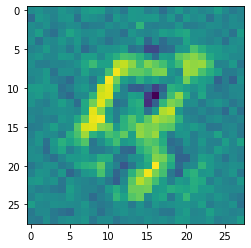

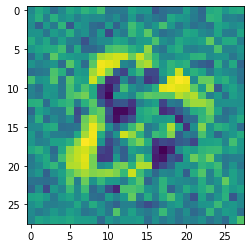

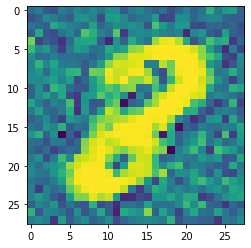

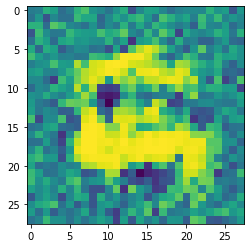

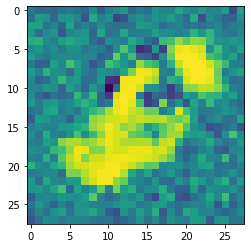

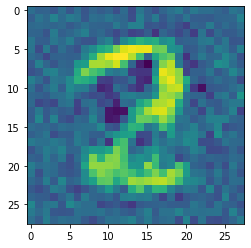

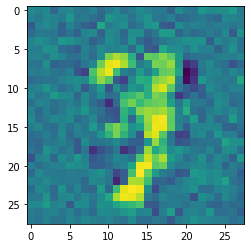

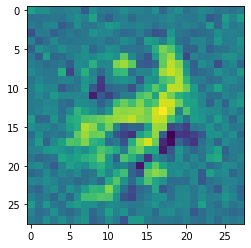

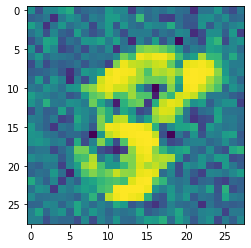

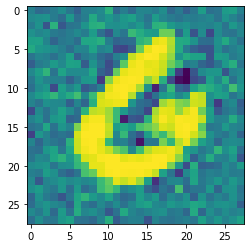

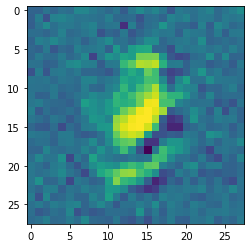

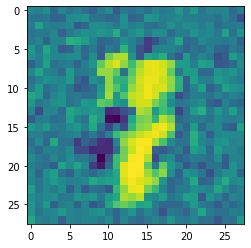

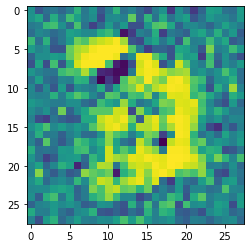

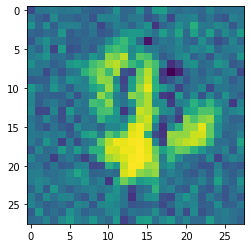

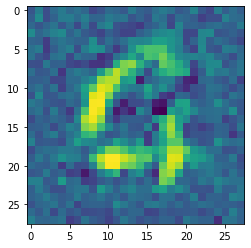

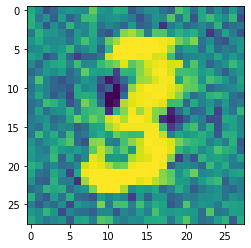

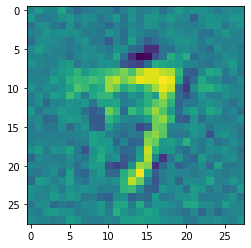

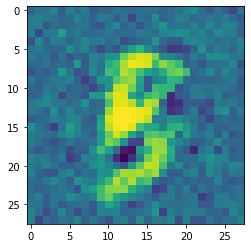

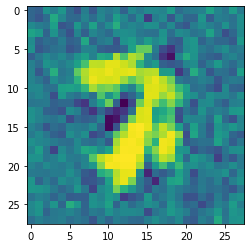

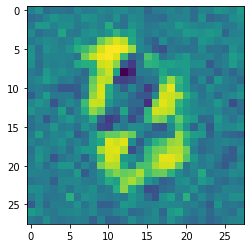

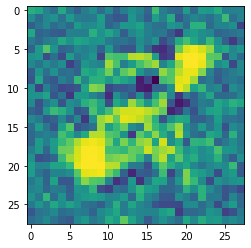

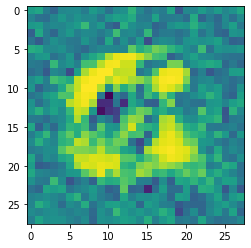

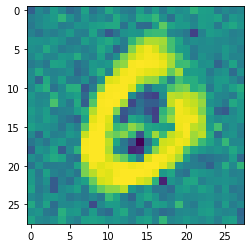

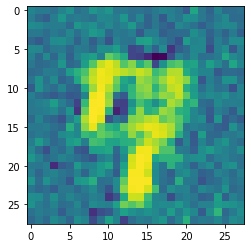

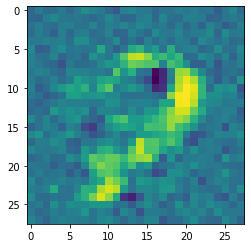

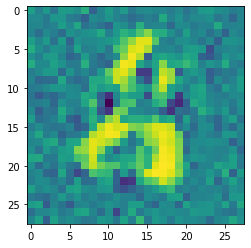

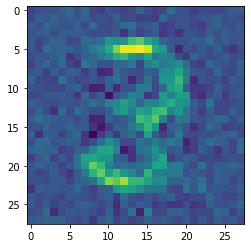

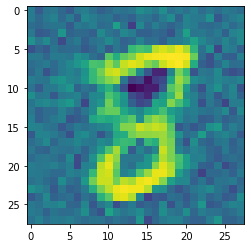

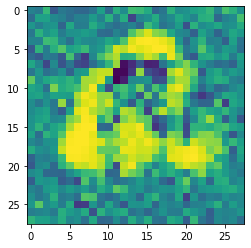

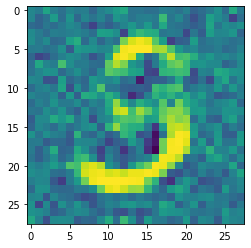

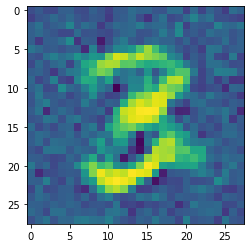

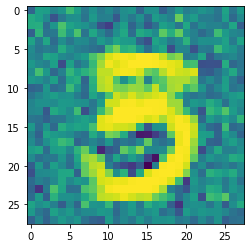

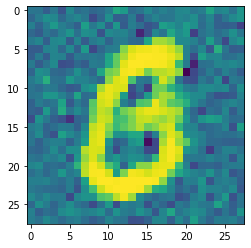

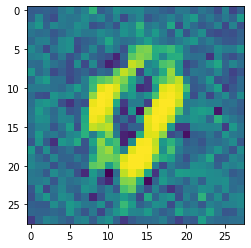

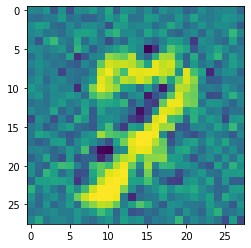

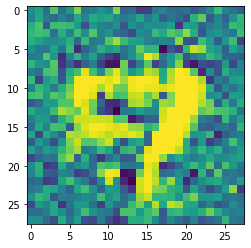

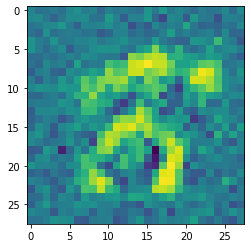

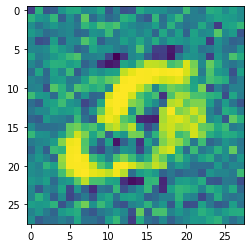

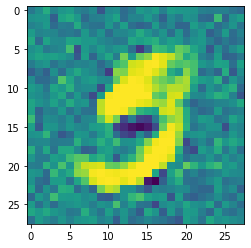

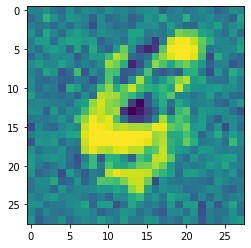

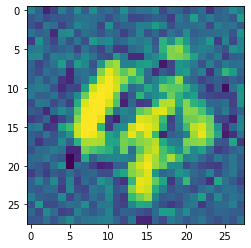

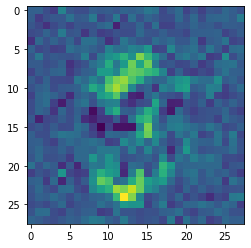

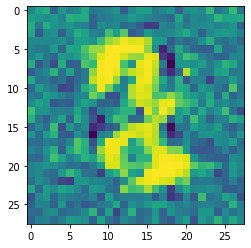

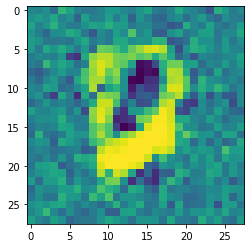

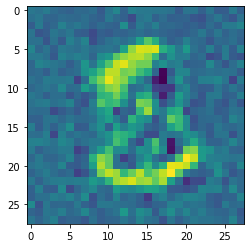

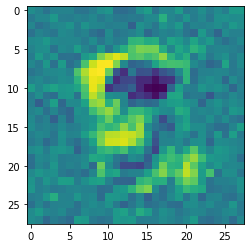

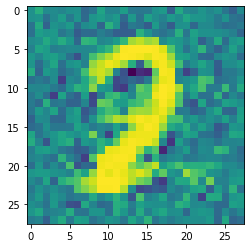

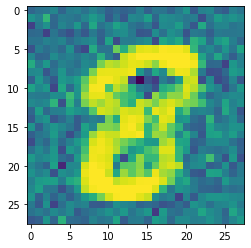

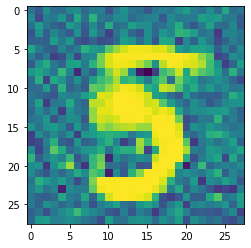

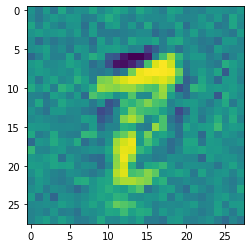

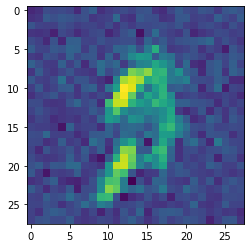

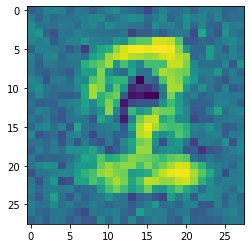

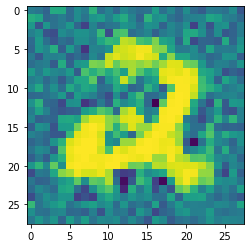

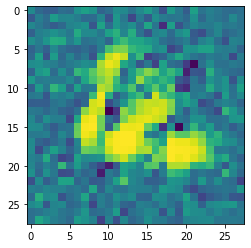

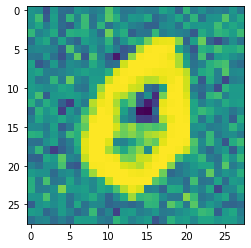

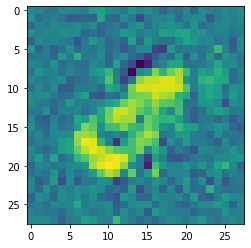

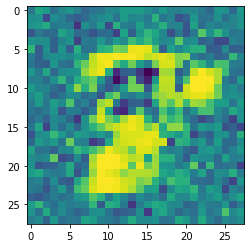

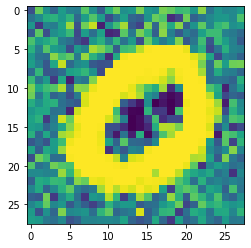

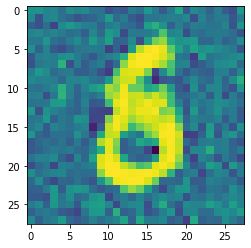

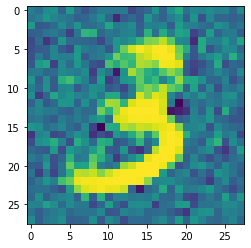

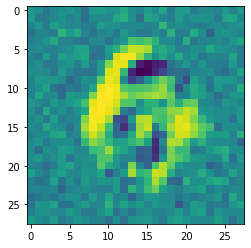

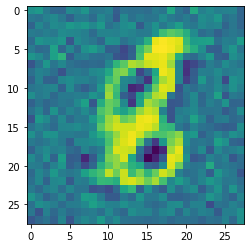

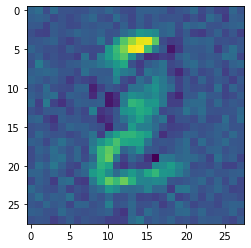

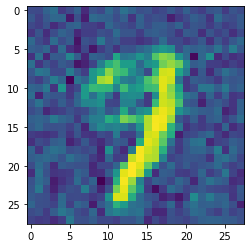

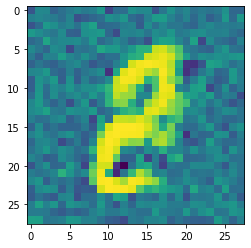

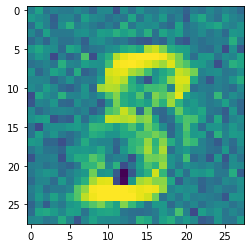

In [0]:
from jax.api import disable_jit
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""A basic MNIST example using JAX with the mini-libraries stax and optimizers.
The mini-library jax.experimental.stax is for neural network building, and
the mini-library jax.experimental.optimizers is for first-order stochastic
optimization.
"""
# x1=[]
# x2=[]

def loss(params_G,params_D,latent_data,inputs):

    G_generated=net_apply_G(params_G,latent_data)
    p1 = net_apply_D(params_D,G_generated)
    p2 = net_apply_D(params_D,inputs)
    loss_D=-np.mean(np.log(p2)+np.log(1-p1))
    loss_G=-loss_D
    # x1.append(loss_G)
    # x2.append(loss_D)
    
    return loss_G,loss_D

# def accuracy(params, batch):
#   inputs, targets = batch
#   target_class = np.argmax(targets, axis=1)
#   predicted_class = np.argmax(net_apply_G(params, inputs), axis=1)
#   return np.mean(predicted_class == target_class)


rng = random.PRNGKey(0)

if __name__ == "__main__":
  rng = random.PRNGKey(0)

  batch_size = 32
  lr_g = 2e-4
  lr_d = 2e-4
  num_epochs = int(1e5)
  #num_epochs=5
  n_targets=10
  n_latent=64
  save_porgress=[]
  n_hidden=256
  n_out=28*28
  net_init_G, net_apply_G = stax.serial(
    Dense(n_hidden),LeakyRelu,
    Dense(n_hidden),LeakyRelu,
    Dense(n_out),Tanh)

  net_init_D, net_apply_D = stax.serial(
    Dense(n_hidden), Relu,
    Dense(n_hidden), Relu,
    Dense(1),Sigmoid)
  
  
  
  train_images, train_labels, test_images, test_labels = mnist()
  num_train = train_images.shape[0]
  num_complete_batches, leftover = divmod(num_train, batch_size)
  num_batches=num_complete_batches

  
  
  num_train = train_images.shape[0]


  opt_init_G, opt_update_G, get_params_G = optimizers.adam(lr_g)# , mass=momentum_mass)
  opt_init_D, opt_update_D, get_params_D = optimizers.adam(lr_d)# , mass=momentum_mass)
  _, init_params_G = net_init_G(rng, (-1, n_latent))
  _, init_params_D = net_init_D(rng, (-1, n_out))
  opt_state_G = opt_init_G(init_params_G)
  opt_state_D = opt_init_D(init_params_D)
  itercount = itertools.count()
  
  
  def data_stream():
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(num_train)
      for i in range(num_batches):
        batch_idx = perm[i * batch_size:(i +1) * batch_size]
        yield train_images[batch_idx], train_labels[batch_idx]
  batches = data_stream()


  @jit
  def update(i, opt_state_G,opt_state_D,latent_dist,inputs):
    #print(inputs)
    params_G = get_params_G(opt_state_G)
    params_D = get_params_D(opt_state_D)
    #print(params_G)
    
    params=(params_G,params_D,latent_dist,inputs)
    _, unravel_G = ravel_pytree(params_G)
    _, unravel_D = ravel_pytree(params_D)

    Df=conj_grad(*params)
    # Df=[grad(lambda *x:loss(*x)[0],argnums=0)(*params),
    #     grad(lambda *x:loss(*x)[1],argnums=1)(*params)]
   
    return opt_update_G(i, unravel_G(Df[0]),opt_state_G), opt_update_D(i,unravel_D(Df[1]),opt_state_D)

  print("\n HI We are training MNIST DATASET")
  plt.imshow(train_images[0].reshape(28,28))
  plt.show()
  print("\nStarting training...")
  for epoch in range(num_epochs):
    latent_dist=onp.random.randn(batch_size, n_latent)
#     print(next(batches))
    #(batch,784) ,(batch,10)
    inputs,targets=next(batches)
    #print(inputs.shape,targets.shape)
    opt_state_G,opt_state_D = update(next(itercount), opt_state_G,opt_state_D,latent_dist,inputs)
#     epoch_time = time.time() - start_time
    #print(opt_state_G)
    params_G = get_params_G(opt_state_G)
    #print(params_G)
    #print(np.array(params_G).shape)
    sample = net_apply_G(params_G, onp.random.randn(1, n_latent))
    #print(sample.shape)
    
    if epoch % 500 == 0: 
       plt.imshow(sample.reshape(28,28))
       #print(targets)
       #print(sample.reshape(28,28))
       plt.show()
       #print(targets.shape)
       #train_acc = accuracy(params_G, (sample, targets))
#     test_acc = accuracy(params_G, (test_images, test_labels))
#     print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
       #print("Training set accuracy {}".format(train_acc))
#     print("Test set accuracy {}".format(test_acc))

In [0]:



# x1=[x1[i].val for i in list(range(len(x1))[::6])]
# x2=[x2[i].val for i in list(range(len(x2))[::6])]


# plt.title("Generator and Discriminator Loss During Training")
# plt.plot(x1,label="G")
# plt.plot(x2,label="D")
# plt.xlabel("iterations")
# plt.ylabel("Loss")
# plt.legend()

# plt.savefig('Loss.pdf')

# plt.show()

In [0]:
# @jit
# def f(x):
#   y = x * 2
#   print("Value of y is", y)
#   return y+3 

# print(f(np.array([1, 2, 3])))


# # with disable_jit():
# #   print(f(np.array([1, 2, 3])))
 

In [0]:
# np.sum(x2)/1000

